## Programming Exercise 2: Logistic Regression

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1 Logistic Regression

In [3]:
datafile = 'data/ex2data1.txt'
#!head $datafile
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X,0,1,axis=1)

#### 1.1 Visualizing the data


In [8]:
#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])
#Check to make sure I included all entries
#print "Included everything? ",(len(pos)+len(neg) == X.shape[0])

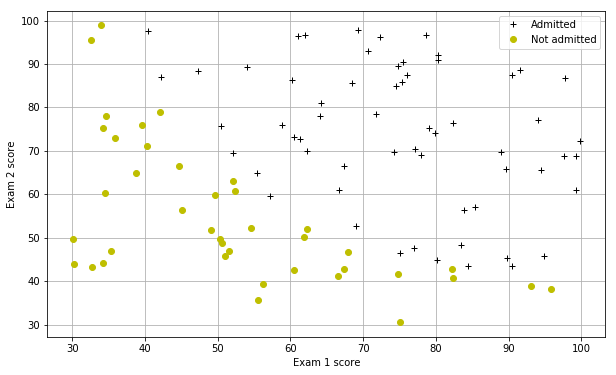

In [12]:
def plotData():
    plt.figure(figsize=(10,6))
    plt.plot(pos[:,1],pos[:,2],'k+',label='Admitted')
    plt.plot(neg[:,1],neg[:,2],'yo',label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.grid(True)
    
plotData()

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

#### Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

#### Partial derivative

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$

#### 1.2 Implementation

In [13]:
from scipy.special import expit #Vectorized sigmoid function

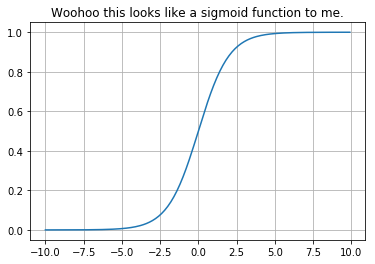

In [14]:
#Quick check that expit is what I think it is
myx = np.arange(-10,10,.1)
plt.plot(myx,expit(myx))
plt.title("Woohoo this looks like a sigmoid function to me.")
plt.grid(True)

In [15]:
#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

#Cost function, default lambda (regularization) 0
def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    Note this includes regularization, if you set mylambda to nonzero
    For the first part of the homework, the default 0. is used for mylambda
    """
    #note to self: *.shape is (rows, columns)
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:])) #Skip theta0
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

In [16]:
#Check that with theta as zeros, cost returns about 0.693:
initial_theta = np.zeros((X.shape[1],1))
computeCost(initial_theta,X,y)

0.6931471805599452

In [17]:
#An alternative to OCTAVE's 'fminunc' we'll use some scipy.optimize function, "fmin"
#Note "fmin" does not need to be told explicitly the derivative terms
#It only needs the cost function, and it minimizes with the "downhill simplex algorithm."
#http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin(computeCost, x0=mytheta, args=(myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]

In [18]:
theta, mincost = optimizeTheta(initial_theta,X,y)
#That's pretty cool. Black boxes ftw

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [20]:
#"Call your costFunction function using the optimal parameters of θ. 
#You should see that the cost is about 0.203."
print (computeCost(theta,X,y))

0.2034977015902151


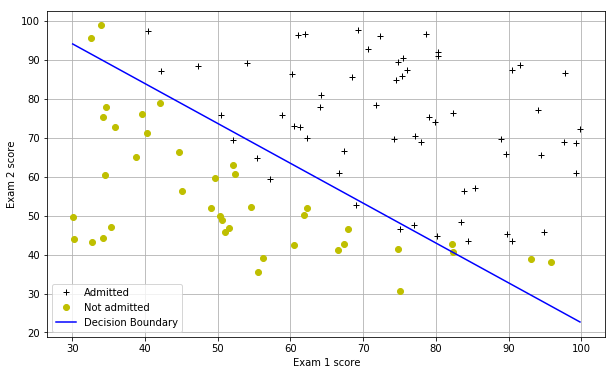

In [21]:
#Plotting the decision boundary: two points, draw a line between
#Decision boundary occurs when h = 0, or when
#theta0 + theta1*x1 + theta2*x2 = 0
#y=mx+b is replaced by x2 = (-1/thetheta2)(theta0 + theta1*x1)

boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plotData()
plt.plot(boundary_xs,boundary_ys,'b-',label='Decision Boundary')
plt.legend()

In [23]:
#For a student with an Exam 1 score of 45 and an Exam 2 score of 85, 
#you should expect to see an admission probability of 0.776.
print (h(theta,np.array([1, 45.,85.])))

0.776291590411


In [26]:
def makePrediction(mytheta, myx):
    return h(mytheta,myx) >= 0.5

#Compute the percentage of samples I got correct:
pos_correct = float(np.sum(makePrediction(theta,pos)))
neg_correct = float(np.sum(np.invert(makePrediction(theta,neg))))
tot = len(pos)+len(neg)
prcnt_correct = float(pos_correct+neg_correct)/tot
print ("Fraction of training samples correctly predicted: %f." % prcnt_correct )

Fraction of training samples correctly predicted: 0.890000.


### 2 Regularized Logistic Regression

#### 2.1 Visualizing the data

In [38]:
datafile = 'data/ex2data2.txt'
#!head $datafile
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X,0,1,axis=1)

In [39]:
#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])
#Check to make sure I included all entries
#print "Included everything? ",(len(pos)+len(neg) == X.shape[0])

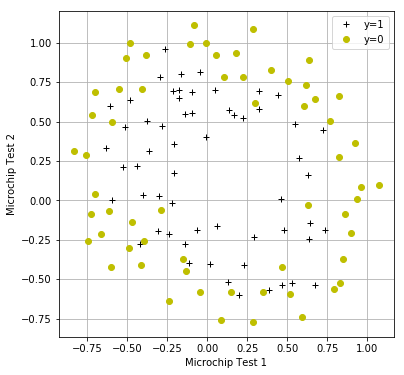

In [40]:
def plotData():
    plt.plot(pos[:,1],pos[:,2],'k+',label='y=1')
    plt.plot(neg[:,1],neg[:,2],'yo',label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

#Draw it square to emphasize circular features
plt.figure(figsize=(6,6))
plotData()

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

#### Partial derivative

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$



#### 2.2 Feature mapping

In [41]:
def mapFeature( x1col, x2col ):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of featuers as described in the homework assignment
    """
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [42]:
#Create feature-mapped X matrix
mappedX = mapFeature(X[:,1],X[:,2])

#### 2.3 Cost function and gradient

In [43]:
#Cost function is the same as the one implemented above, as I included the regularization
#toggled off for default function call (lambda = 0)
#I do not need separate implementation of the derivative term of the cost function
#Because the scipy optimization function I'm using only needs the cost function itself
#Let's check that the cost function returns a cost of 0.693 with zeros for initial theta,
#and regularized x values
initial_theta = np.zeros((mappedX.shape[1],1))
computeCost(initial_theta,mappedX,y)

0.6931471805599453

##### 2.3.1 Learning parameters using fminunc

In [46]:
#noticed that fmin wasn't converging (passing max # of iterations)
#so let's use minimize instead

def optimizeRegularizedTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun
    
theta, mincost = optimizeRegularizedTheta(initial_theta,mappedX,y)

#### 2.4 Plotting the decision boundary

In [47]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,mylambda)
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

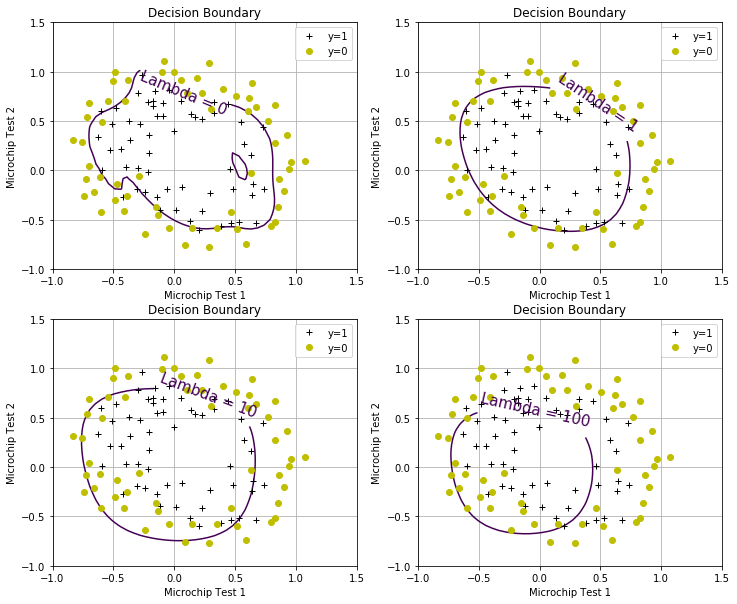

In [48]:
#Build a figure showing contours for various values of regularization parameter, lambda
#It shows for lambda=0 we are overfitting, and for lambda=100 we are underfitting
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1.)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)